In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *

In [38]:
def MSE(x,decoder,encoder=None):
    if encoder is None:
        encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
    l_j_x = encoder(x)
    mse = (F.softmax(l_j_x,dim=1)*((x-decoder.mus.transpose(0,1))**2 + torch.exp(2*decoder.log_sigmas.transpose(0,1)))).sum(dim=1).mean()
    return mse

In [34]:
N_EPOCHS =5000
#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 
print(x_min,x_max)

#encoder = CategoricalEncoder(mu0,sigma0,q0)
N=40
decoder = MoGDecoder(N,x_min,x_max)
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))

#Define optimizer and parameters to iterate on
params =  decoder.parameters()
optimizer = torch.optim.SGD(params,0.01)
loss = simplified_loss(x_data,decoder)


0.00014414434554055333 12.486659049987793


In [30]:
#Ideal loss
lossVec = []
mseVec = []
for epoch in range(N_EPOCHS):
    loss = simplified_loss(x_data,decoder)
    lossVec.append(loss.item())
    #print(torch.softmax(decoder.qs,dim=1))
    mse = MSE_id(x_data,decoder)
    mseVec.append(mse.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


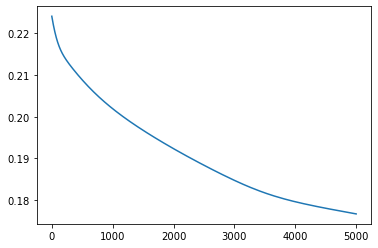

In [33]:
plt.plot(mseVec)

In [35]:
params =  list(encoder.parameters())+list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.01)
lossVec = []
mseVec = []
for epoch in range(N_EPOCHS):
    dis_loss = distortion_cat(x_data,encoder,decoder)
    rate_loss = rate_cat(x_data,encoder,decoder)
    loss = dis_loss + rate_loss
    #loss = simplified_loss(x_data,decoder)
    lossVec.append(loss.item())
    #print(torch.softmax(decoder.qs,dim=1))
    mse = MSE(x_data,encoder,decoder)
    mseVec.append(mse.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [44]:
MSE(x_data,decoder)

tensor(0.1698, grad_fn=<MeanBackward0>)

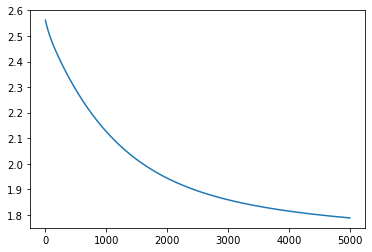

In [37]:
plt.plot(lossVec)